In [1]:
# *** Packages ***
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor

In [2]:
# Set the seed for reproducibility
manual_seed = 42
torch.manual_seed(manual_seed)

Files already downloaded and verified
Files already downloaded and verified


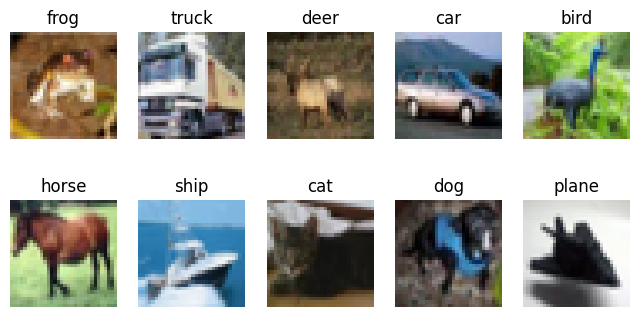

In [3]:
'''
Q2
'''
batch_size = 32

transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0,0,0), std=(1,1,1))])

dataset_train= datasets.CIFAR10(root='./data', train=True, download=True, transform=transformer)#transforms.ToTensor())
trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test= datasets.CIFAR10(root='./data', train=False, download=True, transform=transformer)
#testloader = DataLoader(dataset_test, batch_size=len(dataset_test))
testloader = DataLoader(dataset_test, batch_size=batch_size)


classes_map = {
    0 : 'plane',
    1 : 'car',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

figure = plt.figure(figsize=(8, 4))
cols, rows = 5, 2

# Creiamo un dizionario per tenere traccia delle immagini trovate per ogni classe
class_examples = {}

# Cerchiamo un esempio per ogni classe
for i, (img, label) in enumerate(dataset_train):
        # dataset return img, label 
        # enumerate return i
    if label not in class_examples and len(class_examples) < 10:
        class_examples[label] = img
    if len(class_examples) == 10:
        break

# Plottiamo un'immagine per ogni classe
for i, (label, img) in enumerate(class_examples.items(), 1):
    figure.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)
    plt.title(classes_map[label])
    plt.axis("off")
    plt.imshow(img)

plt.show()

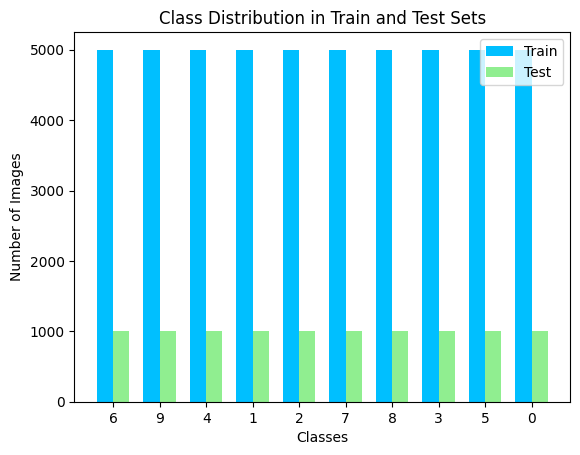

In [4]:
# Funzione per estrarre tutte le etichette dal dataloader
def get_labels_from_loader(loader):
    all_labels = []
    for _, labels in loader:
        all_labels.extend(labels.numpy())  # Estraiamo le etichette come array numpy
    return np.array(all_labels)


# Otteniamo le etichette da train e test e put them into an array
train_label = get_labels_from_loader(trainloader)
test_label = get_labels_from_loader(testloader)

# Calcoliamo la distribuzione delle classi
_, train_counts = np.unique(train_label, return_counts=True)
_, test_counts = np.unique(test_label, return_counts=True)

# Creiamo il grafico comparativo
bar_width = 0.35
index = np.arange(len(class_examples))

plt.bar(index, train_counts, bar_width, label='Train', color='deepskyblue')
plt.bar(index + bar_width, test_counts, bar_width, label='Test', color='lightgreen')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Train and Test Sets')
plt.xticks(index + bar_width / 2, class_examples)
plt.legend()
plt.show()

In [5]:
# Stampiamo i valori
print("\nNumero di immagini per classe:")
print(f"{'Classe':<10} {'Training':<10} {'Test':<10}")
print("-" * 30)
for i in range(10):
    print(f"{classes_map[i]:<10} {train_counts[i]:<10} {test_counts[i]:<10}")


Numero di immagini per classe:
Classe     Training   Test      
------------------------------
plane      5000       1000      
car        5000       1000      
bird       5000       1000      
cat        5000       1000      
deer       5000       1000      
dog        5000       1000      
frog       5000       1000      
horse      5000       1000      
ship       5000       1000      
truck      5000       1000      


In [6]:
'''
Q3
'''
trainiter = iter(trainloader)
train_images, _ = next(trainiter)

testiter = iter(testloader)
test_images, _ = next(testiter)


# Prendi la prima immagine del batch
first_image = train_images[0]

print(f"Type of each image: {first_image.type}")

# Stampa la dimensione dell'immagine
print(f"Shape of the image tensor: {first_image.shape}")  # (C, H, W)

# Puoi separare in Channels, Height, Width
channels, height, width = first_image.shape
print(f"Width: {width}, Height: {height}, Channels: {channels}")

Type of each image: <built-in method type of Tensor object at 0x7a45074eea70>
Shape of the image tensor: torch.Size([3, 32, 32])
Width: 32, Height: 32, Channels: 3


In [7]:
'''
Q5
'''
dataset_val, dataset_test = torch.utils.data.random_split(dataset_test, [0.5, 0.5])

#validloader = DataLoader(dataset_val, batch_size=len(dataset_val))
testloader = DataLoader(dataset_test, batch_size=len(dataset_test))
validloader = DataLoader(dataset_val, batch_size=batch_size)

print(len(trainloader), len(validloader))

1563 157


In [8]:
'''
Q6
'''
def out_dimensions(conv_layer, h_in, w_in):
    '''
    This function computes the output dimension of each convolutional layers in the most general way. 
    '''
    h_out = floor((h_in + 2 * conv_layer.padding[0] - conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) /
                  conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) /
                  conv_layer.stride[1] + 1)
    return h_out, w_out
    
class CNNB(nn.Module):
    def __init__(self):
        super(CNNB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv1, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv4, h_out, w_out)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        self.dimensions_final = (64, h_out, w_out)
        self.fc1 = nn.Linear(64 * h_out * w_out, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [9]:
    
'''
Q7
'''
model = CNNB()
learning_rate = 0.029
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)


n_epochs = 4
n_steps = 50

train_acc_list, eval_acc_list = [], []
train_loss_list, validation_loss_list = [], []
train_loss_list_epochs, eval_loss_list_epochs = [], []

#for epoch in range(n_epochs):
#    # Reset training counters for each epoch
#    n_samples_train, n_correct_train = 0, 0
#    loss_train = 0

#    for step, (data, target) in enumerate(trainloader):
#        model.train()
#        data, target = data.to(DEVICE), target.to(DEVICE)

#        optimizer.zero_grad()
#        output = model(data)
#        _, predicted = torch.max(output.data, 1)

#        # Update counts
#        n_samples_train += target.size(0)
#        n_correct_train += (predicted == target).sum().item()

        # Compute and accumulate loss
#        loss = loss_fn(output, target)
#        loss_train += loss.item()
#        loss.backward()
#        optimizer.step()
        
        # Log training metrics every n_steps
#        if (step + 1) % n_steps == 0:
#            acc_train = 100.0 * n_correct_train / n_samples_train
#            avg_loss_train = loss_train / (step + 1)  # Average loss up to current step
#            train_loss_list.append(avg_loss_train)
#            train_acc_list.append(acc_train)
#            print(f"Epoch [{epoch+1}/{n_epochs}], Step [{step+1}/{len(trainloader)}]")
#            print(f"Training Accuracy: {acc_train:.2f}%")
#            print(f"Training Loss: {avg_loss_train:.4f}")

#    # Save the last computed training loss of the epoch
#    last_loss_train = loss_train / len(trainloader)  # Final averaged loss for the epoch
#    train_loss_list_epochs.append(last_loss_train)
    
#    # Validation phase
#    model.eval()
#     n_samples_eval, n_correct_eval = 0, 0
#     loss_eval = 0
    
#     with torch.no_grad():
#         for step, (data, target) in enumerate(validloader):
#             data, target = data.to(DEVICE), target.to(DEVICE)
#             output = model(data)
#             _, predicted = torch.max(output.data, 1)

#             # Update evaluation counts
#             n_samples_eval += target.size(0)
#             n_correct_eval += (predicted == target).sum().item()
            
#             # Compute and accumulate validation loss
#             loss = loss_fn(output, target)
#             loss_eval += loss.item()

#             # Log validation metrics every n_steps
#             if (step + 1) % n_steps == 0:
#                 acc_eval = 100.0 * n_correct_eval / n_samples_eval
#                 avg_loss_eval = loss_eval / (step + 1)  # Average loss up to current step
#                 validation_loss_list.append(avg_loss_eval)
#                 eval_acc_list.append(acc_eval)
#                 print(f"Step [{step+1}/{len(validloader)}]")
#                 print(f"Validation Accuracy: {acc_eval:.2f}%")
#                 print(f"Validation Loss: {avg_loss_eval:.4f}")
        
#         # Save the last computed validation loss of the epoch
#         last_loss_eval = loss_eval / len(validloader)  # Final averaged loss for the epoch
#         eval_loss_list_epochs.append(last_loss_eval)
#         acc_eval = 100.0 * n_correct_eval / n_samples_eval
#         print(f"Epoch [{epoch+1}/{n_epochs}], Validation Loss: {last_loss_eval:.4f}, Validation Accuracy: {acc_eval:.2f}%")


# # test
# with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     for data, target in testloader:
#         data, target = data.to(DEVICE), target.to(DEVICE)
#         outputs = model(data)
#         _, predicted = torch.max(outputs.data, 1)
#         n_samples += target.size(0)
#         n_correct += (predicted == target).sum().item()

#     acc = 100.0 * n_correct / n_samples
# print("Accuracy on the test set:", acc, "%")

# print(len(train_loss_list), len(validation_loss_list))
# print(len(train_loss_list_epochs), len(eval_loss_list_epochs))

Working on cuda


In [10]:
'''
Q8
'''
# plt.figure()
# plt.plot(range(n_epochs), train_loss_list_epochs)
# plt.plot(range(n_epochs), eval_loss_list_epochs)
# plt.legend(["Train loss", "Validation Loss"])
# plt.xlabel("Epochs")
# plt.ylabel("Loss value")
# plt.savefig("lossBasicKaggle")
# plt.show()

'\nQ8\n'

In [11]:
'''
Q9
'''
class CNNGodzilla(nn.Module):
    def __init__(self):
        super(CNNGodzilla, self).__init__()
        
        # First block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, stride=1)
        h_out, w_out = out_dimensions(self.conv1, 32, 32)  # 32x32
        self.BN1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, stride=1)
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)  # 32x32
        self.BN2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)  # 16x16
        
        # Second block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, stride=1)
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)  # 16x16
        self.BN3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, stride=1)
        h_out, w_out = out_dimensions(self.conv4, h_out, w_out)  # 16x16
        self.BN4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)  # 8x8
        
        # Third block
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, stride=1)
        h_out, w_out = out_dimensions(self.conv5, h_out, w_out)  # 8x8
        self.BN5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, stride=1)
        h_out, w_out = out_dimensions(self.conv6, h_out, w_out)  # 8x8
        self.BN6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)  # 4x4
        
        # Flatten
        self.flatten = nn.Flatten()
        
        # Store final dimensions for the forward pass
        self.dimensions_final = (256, h_out, w_out)  # Should be (256, 4, 4)
        
        # Fully Connected
        self.fc1 = nn.Linear(256 * h_out * w_out, 128)  # 256 * 4 * 4 = 4096 input features
        self.BN7 = nn.BatchNorm1d(128)
        self.Dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 64)
        self.BN8 = nn.BatchNorm1d(64)
        self.Dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.BN1(x)
        x = F.gelu(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = F.gelu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.BN3(x)
        x = F.gelu(x)
        x = self.conv4(x)
        x = self.BN4(x)
        x = F.gelu(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = self.BN5(x)
        x = F.gelu(x)
        x = self.conv6(x)
        x = self.BN6(x)
        x = F.gelu(x)
        x = self.pool3(x)

        x = self.flatten(x) # istruzione prof

        x = self.fc1(x)
        x = self.BN7(x)
        x = F.gelu(x)
        x = self.Dropout1(x)

        x = self.fc2(x)
        x = self.BN8(x)
        x = F.gelu(x)
        x = self.Dropout2(x)

        x = self.fc3(x)
        return x

In [12]:
batch_size = 32

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),  
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

dataset_train= datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [13]:
model = CNNGodzilla()
learning_rate = 0.028
# con 0.3 81% ottima loss con 20 random
# 0.32 80% spike più alti
# 0.28 80% carino
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

train_loss_list = []
validation_loss_list = []
n_epochs = 8 # with the introductions of the Dropout who avoid overfitting we can add some epochs

for epoch in range(n_epochs):
    loss_train = 0
    for data, target in trainloader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
        
    loss_train = loss_train / len(trainloader) # Consider this alternative method of tracking training loss. 
    train_loss_list.append(loss_train)
    
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validloader: # Just one batch
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
    print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}")
    validation_loss_list.append(validation_loss)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Working on cuda
Epoch 1: Train loss: 1.5589959179828812, Validation loss 1.2064285278320312
Epoch 2: Train loss: 1.2122739338371438, Validation loss 0.8965604901313782
Epoch 3: Train loss: 1.0546447756346875, Validation loss 0.5227982401847839
Epoch 4: Train loss: 0.9530398250579529, Validation loss 0.6581847667694092
Epoch 5: Train loss: 0.882074883921514, Validation loss 0.3733348548412323
Epoch 6: Train loss: 0.8235178010363039, Validation loss 0.23488719761371613
Epoch 7: Train loss: 0.7862500785560999, Validation loss 0.44459715485572815
Epoch 8: Train loss: 0.7384246560296261, Validation loss 0.28564590215682983
Accuracy on the test set: 80.2 %


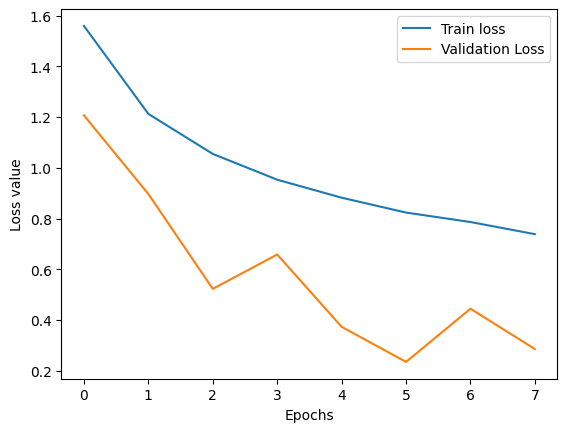

In [14]:
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.savefig(f"lossGodzilla")
plt.show()

In [15]:
'''
Q10 -  Code
'''
for seed in range(5,10):
    torch.manual_seed(seed)
    print("Seed equal to ", torch.random.initial_seed())
    # Train the models here
        
    model = CNNB()
    learning_rate = 0.0302
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
        if torch.backends.mps.is_available() else 'cpu')
    model = model.to(DEVICE)
    print("Working on", DEVICE)

    train_loss_list = []
    validation_loss_list = []
    n_epochs = 4 # with the introductions of the Dropout who avoid overfitting we can add some epochs

    for epoch in range(n_epochs):
        loss_train = 0
        for data, target in trainloader:
            # Set the model in training mode
            model.train()
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Set the gradient to 0
            optimizer.zero_grad()
            # Make a prediction
            output = model(data)
            # Compute the loss function
            loss = loss_fn(output, target)
            loss_train += loss.item()
            # Backpropagation
            loss.backward()
            # Update parameters
            optimizer.step()

        loss_train = loss_train / len(trainloader) # Consider this alternative method of tracking training loss. 
        train_loss_list.append(loss_train)
    
        # At the end of every epoch, check the validation loss value
        with torch.no_grad():
            model.eval()
            for data, target in validloader: # Just one batch
                data, target = data.to(DEVICE), target.to(DEVICE)
                # Make a prediction
                output = model(data)
                # Compute the loss function
                validation_loss = loss_fn(output, target).item()
        print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}")
        validation_loss_list.append(validation_loss)

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for data, target in testloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += target.size(0)
            n_correct += (predicted == target).sum().item()

        acc = 100.0 * n_correct / n_samples
    print("Accuracy on the test set:", acc, "%")

Seed equal to  5
Working on cuda


KeyboardInterrupt: 